In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv("source_2021-12-07-09-51-43.csv", parse_dates = ["start_date", "end_date"], dtype={'work_postal':'str'})

In [2]:
#Replace under_29 by .under_29 to make it easier when sorting
df['age_group'] = df['age_group'].replace(to_replace='under_29', value='.under_29')

#Fill in na values for age_group
df['age_group'] = df['age_group'].fillna(df['age_group'].value_counts().index[0])

#Replace missing values in event column with unknown
df['event'] = df['event'].fillna('unknown')

#Drop all temportary positions
df = df[~df['jobtitle'].str.contains("TEMP")]

In [3]:
temp_end_date = pd.to_datetime('2021-12-07')
employee_ids = df.emplid_sec.unique()

#Define list of features we want in our model
duration = []
comprate = []
last_pay_raise = []
age_group = []
pay_increase_ot = []
piot_compared_avg = []
event = []

for ID in employee_ids:
    #Get all records of the employee
    employee = df[df['emplid_sec'] == ID].copy()
    
    ##### DURATION #####
    #Add up all durations (there are some inaccuracies doing this)
    duration.append(sum(employee['duration'].tolist(), employee.shape[0]))
    
    ##### COMP RATE #####
    #Get the highest comprate
    comprate.append(max(employee['comprate'].tolist()))
    
    ##### LAST PAY RAISE #####
    #Get last date of work or temporary last date
    if(employee['end_date'].isna().sum()):
        end = temp_end_date
    else:
        end = employee['end_date'].sort_values().tolist()[-1]
    #Get date of last pay raise
    employee.sort_values(by=['comprate'], inplace=True)
    last_raise = employee.iloc[-1]['start_date']
    #Calculate the difference
    last_pay_raise.append((end - last_raise).days)
    
    ##### AGE GROUP #####
    #Get the age group they were before they left
    age_group.append(sorted(employee['age_group'].tolist())[-1])
    
    ##### PAY INCREASE OVER TIME #####
    #(max - min) / duration
    max_rate = max(employee['comprate'].tolist())
    min_rate = min(employee['comprate'].tolist())
    pay_increase_ot.append((max_rate - min_rate) / duration[-1])
    
    ##### EVENT #####
    #Get the employee's latest event
    employee.sort_values(by=['end_date'], inplace=True)
    #Currently working
    if(pd.isnull(employee.iloc[-1]['end_date'])):
        event.append('Working')
    else:
        event.append(employee.iloc[-1]['event'])
        
avg_pay_increase_ot = sum(pay_increase_ot) / len(pay_increase_ot)
##### COMPRATE INCREASE OVER TIME COMPARED TO AVERAGE #####
#calculate the % below or above average
for val in pay_increase_ot:
    piot_compared_avg.append((val - avg_pay_increase_ot) / avg_pay_increase_ot)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

In [5]:
data = {'duration': duration,
        'comprate': comprate,
        'last_pay_raise': last_pay_raise,
        'age_group': age_group,
        'pay_increase_ot': pay_increase_ot,
        'piot_compared_avg': piot_compared_avg,
        'event': event}
model_df = pd.DataFrame(data)

#Drop data points with 'unknown' event
model_df = model_df[model_df['event'] != 'unknown']

#Define input and output parameters for model
X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

#Encode labels for age_group
le = LabelEncoder()
le.fit(X['age_group'])
X['age_group'] = le.transform(X['age_group'])

#Encode labels for y and save the mapping
le.fit(y)
event_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(event_mapping)
y = le.transform(y)

{'Retirement': 0, 'Termination': 1, 'Working': 2}


In [6]:
#logistic_model.fit(X,Y)
#importance = logistic_model.coef_[0]
#importance is a list so you can plot it. 
#feat_importances = pd.Series(importance)
#feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

import numpy as np
model = LogisticRegression()
model.fit(X, y)
#plot_importance(model)
#pyplot.show()
feature_labels = np.array(['duration', 'comprate', 'last_pay_rise', 'age_group', 'pay_increase_ot', 
      'pivot_compared_avg'])
importance = model.coef_[0]
feature_indexes_by_importance = np.argsort(importance)
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100 )))


#Save predictions
y_pred = cross_val_predict(model, X, y)

#Confusion matrix
matrix = confusion_matrix(y, y_pred)
print(matrix.diagonal()/matrix.sum(axis=1))

#F1 weighted 
result = cross_validate(model, X, y, scoring='f1_weighted')
print(result['test_score'])

c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


comprate--7.78%
pivot_compared_avg--2.28%
pay_increase_ot--0.02%
last_pay_rise-0.02%
duration-0.02%
age_group-25.17%


c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

[0.47339782 0.71663244 0.5317823 ]


c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

[0.38828341 0.55188726 0.70834432 0.70089197 0.57550342]


c:\users\smitm\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<AxesSubplot:title={'center':'Feature Importance'}>

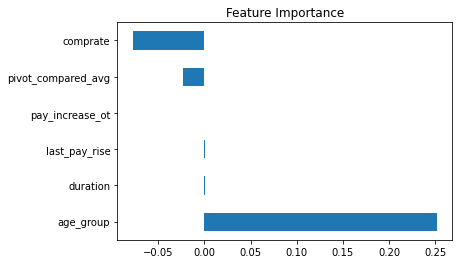

In [7]:
feat_importances = pd.Series(importance, index=feature_labels)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')